In [1]:
import re
import os
import glob
import shutil
from distutils.util import strtobool
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import dask
import dask.dataframe as dd
from tqdm.notebook import tqdm

# Set Seaborn theme and default palette
sns.set_context("talk")
sns.set_theme(font_scale=1.25, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
# Import my modules
from tools import language as lang, plotting, utils

DOWNLOAD = False
INIT_EXPORT = False

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

dask.config.set(scheduler="processes")

<IPython.core.display.Javascript object>

# Sourcing the Data

The product data I've chosen doesn't come directly from Amazon, but rather from three AI researchers, Jianmo Ni, Jiacheng Li, and Julian McAuley, who gathered it for their paper "Justifying Recommendations using Distantly-Labeled Reviews and Fine-grained Aspects." The review data extends from May 1996 to October 2018, which is about when they released the update. Their focus was primarily on reviews, but the dataset also has metadata for ~15-million products.

#### The purpose of this notebook is to obtain the data, clean it, and reduce it to a more manageable size.

# Downloading the Data

For an overview of the dataset, see `main_notebook.ipynb`. This notebook developed out of practical necessity, due to the unwieldy size of the dataset (~15M samples). I needed a space to reduce the dataset to a more manageable ~4M.

I begin by downloading the data from some kindly academic researchers. Either run the following cell or use the [link](http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/All_Amazon_Meta.json.gz) to download the file to `data/amazon_raw.json.gz`. The researchers request that you fill out a [short form](https://forms.gle/A8hBfPxKkKGFCP238) if you download the data.

This single compressed JSON file is not ideal for such a large, 15-million product dataset. After the download completes, I'll export the it to Apache Parquet. Parquet is a (much faster) binary format which is designed for fast IO on large datasets.

In [3]:
src = "http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/All_Amazon_Meta.json.gz"
dst = "data/amazon_raw.json.gz"

if DOWNLOAD:
    # Adjust `chunk_size` as necessary
    utils.download(src, dst, chunk_size=10 ** 7)

<IPython.core.display.Javascript object>

Now I'm ready for the export, assuming `INIT_EXPORT` is set. This may take a while. It would be faster to use Dask here than Pandas, but Dask doesn't support chunked reading of compressed JSONs.

In [4]:
if INIT_EXPORT:
    cols = [
        "description",
        "title",
        "feature",
        "brand",
        "main_cat",
        "category",
    ]
    json_path = os.path.normpath("data/amazon_raw.json.gz")
    out_dir = os.path.normpath("data/amazon_raw")

    print(f"Exporting to {out_dir}...")
    # Make sure empty directory exists
    if os.path.isdir(out_dir):
        shutil.rmtree(out_dir)
    os.makedirs(out_dir)
    reader = pd.read_json(json_path, lines=True, chunksize=10 ** 5)

    with tqdm(total=14_874_972) as pbar:
        for i, chunk in enumerate(reader):
            chunk = chunk.drop_duplicates(subset=["asin"]).set_index("asin")
            chunk = chunk.loc[:, cols]
            out_path = os.path.join(out_dir, f"part.{i}.parquet")
            chunk.to_parquet(
                out_path,
                engine="pyarrow",
                index=True,
            )
            pbar.update(len(chunk))

<IPython.core.display.Javascript object>

# Initial Pruning

In [5]:
cols = ["description", "main_cat", "asin"]
df = dd.read_parquet("data/amazon_raw", engine="pyarrow", columns=cols)
print(f"n_samples: {df.index.size.compute():,.0f}")
df

n_samples: 15,023,059


,description,main_cat,asin
npartitions=151,,,
,object,object,object
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


<IPython.core.display.Javascript object>

In [6]:
df = df.dropna(subset=["description", "main_cat"])
df.head()

,description,main_cat,asin
0,[(=^ ^=) 1.It is made of high quality material...,Movies & TV,6305121869
1,"[<b><br>Hi friend, welcome to our store. Befor...","<img src=""https://images-na.ssl-images-amazon....",6318708057
2,[Gaok men's pants are all made from cotton mat...,"<img src=""https://images-na.ssl-images-amazon....",6342506256
3,[<b>pant size(Unit:inch)</b><br> W30(tag30) Wa...,"<img src=""https://images-na.ssl-images-amazon....",6342509379
4,[All of our sunglasses offer protection agains...,Sports & Outdoors,6342522081


<IPython.core.display.Javascript object>

In [7]:
df = df.compute()
df

,description,main_cat,asin
0,[(=^ ^=) 1.It is made of high quality material...,Movies & TV,6305121869
1,"[<b><br>Hi friend, welcome to our store. Befor...","<img src=""https://images-na.ssl-images-amazon....",6318708057
2,[Gaok men's pants are all made from cotton mat...,"<img src=""https://images-na.ssl-images-amazon....",6342506256
3,[<b>pant size(Unit:inch)</b><br> W30(tag30) Wa...,"<img src=""https://images-na.ssl-images-amazon....",6342509379
4,[All of our sunglasses offer protection agains...,Sports & Outdoors,6342522081
...,...,...,...
22121,"[, CND Craft Culture Collection: Patina Buckle...",Luxury Beauty,B01HIQIEYC
22122,[CND Shellac was designed to be used as a syst...,Luxury Beauty,B01HIQHQU0
22123,[CND Shellac was designed to be used as a syst...,Luxury Beauty,B01HIQEOLO
22124,[The I AM JUICY COUTURE girl is once again tak...,Luxury Beauty,B01HJ2UY0W


<IPython.core.display.Javascript object>

In [8]:
df["description"] = df.loc[:, "description"].str.join(" ")
df.head()

,description,main_cat,asin
0,(=^ ^=) 1.It is made of high quality materials...,Movies & TV,6305121869
1,"<b><br>Hi friend, welcome to our store. Before...","<img src=""https://images-na.ssl-images-amazon....",6318708057
2,Gaok men's pants are all made from cotton mate...,"<img src=""https://images-na.ssl-images-amazon....",6342506256
3,<b>pant size(Unit:inch)</b><br> W30(tag30) Wai...,"<img src=""https://images-na.ssl-images-amazon....",6342509379
4,All of our sunglasses offer protection against...,Sports & Outdoors,6342522081


<IPython.core.display.Javascript object>

I drop duplicates with respect to the ID feature 'asin', and with respect to 'description'. Weeding out duplicate descriptions reduces the influence of boilerplate copy-paste style product descriptions.

In [9]:
df = df.drop_duplicates(subset=["asin"])
df = df.drop_duplicates(subset=["description"])
df.shape

(8244935, 3)

<IPython.core.display.Javascript object>

In [10]:
df = df.set_index("asin")
df.head()

,description,main_cat
asin,,
6305121869,(=^ ^=) 1.It is made of high quality materials...,Movies & TV
6318708057,"<b><br>Hi friend, welcome to our store. Before...","<img src=""https://images-na.ssl-images-amazon...."
6342506256,Gaok men's pants are all made from cotton mate...,"<img src=""https://images-na.ssl-images-amazon...."
6342509379,<b>pant size(Unit:inch)</b><br> W30(tag30) Wai...,"<img src=""https://images-na.ssl-images-amazon...."
6342522081,All of our sunglasses offer protection against...,Sports & Outdoors


<IPython.core.display.Javascript object>

# Pruning Length Outliers

I want to reduce the dataset to a more manageable size by selecting only the most valuable parts. Document vectors can be normalized to adjust for varying document length, but there are still reasons to pay attention to it. Short documents contain very few terms, and thus very little information. The vectors representing short documents are more coarse-grained and crude than those representing long ones.

On the other hand, some documents may contain too much information. Extremely long documents may contain pages upon pages of irrelevant details. For example, the product description for a book might be the entire first chapter. They also may contain artifacts which inflate their length, such lists of codes or blocks of artificial language (e.g. HTML, JavaScript).

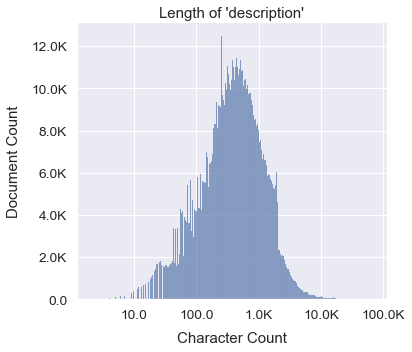

<IPython.core.display.Javascript object>

In [11]:
fig = lang.length_dist(
    data=df.sample(10 ** 6), subset="description", log_scale=True, tick_prec=1
)

If it looks normally distributed, that's because it's plotted on a logarithmic scale. The description lengths vary in orders of magnitude.

In [12]:
# Print stats
lang.length_info(df["description"])

       len_description
count        8,244,935
mean               667
std              1,122
min                  0
25%                175
50%                387
75%                803
max            278,061


<IPython.core.display.Javascript object>

The longest description is ~280K characters and the shortest is 0 characters. Let's take a look at the longest.

In [13]:
df.loc[df.description.str.len().idxmax(), "description"]

'<div>Bryan Bunch has extensive experience as a writer and editor in the math and science fields. The editor of <i>The Family Encyclopedia of Diseases</i>, he is also the co-author, with Alexander Hellemans, of <i>The Timetables of Science</i> and the author of <i>Mathematical Fallacies and Paradoxes</i> and <i>Reality\'s Mirror: Exploring the Mathematics of Symmetry</i>, which was named one of the year\'s best science books by <i>Library Journal. </i> He lives in Pleasant Valley, New York.<br></div> <DIV>The Kingdom of Infinite Numbers<BR></div><DIV><DIV>Kingdom Number</div></div><DIV><DIV>Genus <i>Natural</i> (Counting Numbers)</div><DIV>In some societies, counting language has not evolved beyond 2 or 3 and a word that means "many" for higher numbers. From a linguistic point of view the counting numbers, at least those greater than 2 or 3, may be considered a human invention.</div><DIV>Yet there is something natural about the genus <i>Natural.</i> If the concept of matching, or one-t

<IPython.core.display.Javascript object>

It's not weird, but it's filled with HTML formatting. Reminds me a philosophy of mathematics course I once took. It'd make me a little sad to drop this one, though it does contain a lot of irrelevant detail.

Next, I'll strip out HTML tags to get more useful length measurements.

In [14]:
df["description"] = lang.strip_html_tags(df.loc[:, "description"], n_jobs=-1)
df.head()

,description,main_cat
asin,,
6305121869,(=^ ^=) 1.It is made of high quality materials...,Movies & TV
6318708057,"Hi friend, welcome to our store. Before purcha...","<img src=""https://images-na.ssl-images-amazon...."
6342506256,Gaok men's pants are all made from cotton mate...,"<img src=""https://images-na.ssl-images-amazon...."
6342509379,pant size(Unit:inch) W30(tag30) Waist: 30.0 Hi...,"<img src=""https://images-na.ssl-images-amazon...."
6342522081,All of our sunglasses offer protection against...,Sports & Outdoors


<IPython.core.display.Javascript object>

In [15]:
df.sort_values(
    "description",
    key=lambda x: x.str.len(),
    ascending=False,
    inplace=True,
)
df.head(20)

,description,main_cat
asin,,
0716744473,Bryan Bunch has extensive experience as a writ...,Books
067164811X,Daniel Reid was born and educated in America a...,Books
0312006705,Peter Hathaway Capstick is the author of many ...,Books
0312354614,Terry J. Erdmann is the author or co-author of...,Books
0671763326,Jack Maguire author of Creative Storytelling a...,Books
0716741717,J. Warren Evans is Professor of Animal Science...,Books
0312329288,Ellen Datlow is the acclaimed editor of such a...,Books
0441015026,"Alastair Reynolds was born in Barry, South Wal...",Books
0142437859,Emma Goldman (1869&ndash;1940) came to America...,Books


<IPython.core.display.Javascript object>

All the longest descriptions are for books. That's hardly surprising. Let's look at the one that's not a book, B00LQDEF5Q.

In [16]:
df.at["B00LQDEF5Q", "description"]

'Manufacturer Model Number KitchenAid KUDS01DJSS0 KitchenAid KUDS01FLSS6 KitchenAid KUDS01FLSS2 KitchenAid KUDS01FLSS1 KitchenAid KUDS01IJBS0 KitchenAid KUDR01TJBL0 KitchenAid KUDS01FLSS3 KitchenAid KUDS01DJBL0 KitchenAid KUDM01TJBL0 KitchenAid KUDS01IJWH0 KitchenAid KUDM01TJBS0 KitchenAid KUDP01FLSS1 KitchenAid KUDR01TJWH0 KitchenAid KUDS01FLSS5 KitchenAid KUDP01FLSS6 Whirlpool GU1100XTLQ1 KitchenAid KUDI01TJBL0 KitchenAid KUDP01FLSS3 KitchenAid KUDS01IJBL0 KitchenAid KUDS01FKSS0 KitchenAid KUDI01FLSS6 KitchenAid KUDM01TJWH0 KitchenAid KUDP01FLSS2 KitchenAid KUDI01FLSS3 KitchenAid KUDI01ILBL2 KitchenAid KUDI01FLSS2 KitchenAid KUDS01FLSS0 Whirlpool GU1200XTLB3 KitchenAid KUDS01FKSS1 KitchenAid KUDS02FRSS1 Whirlpool GU2400XTPS3 KitchenAid KUDM01TJBT0 KitchenAid KUDI01ILBL6 Whirlpool GU1100XTLB1 Whirlpool GU1500XTLQ1 KitchenAid KUDS02FRSS0 KitchenAid KUDI01ILBL3 KitchenAid KUDS01FLBL1 KitchenAid KUDI01TJWH0 KitchenAid KUDI01FLSS1 KitchenAid KUDP01FLSS0 KitchenAid KUDP01FLSS5 KitchenAid K

<IPython.core.display.Javascript object>

And there you have it, an obnoxiously long list of SKUs. I'll drop the longest 1%.

Since I want to create a relatively fine-grained vector space, I'll also drop the shortest 50%.

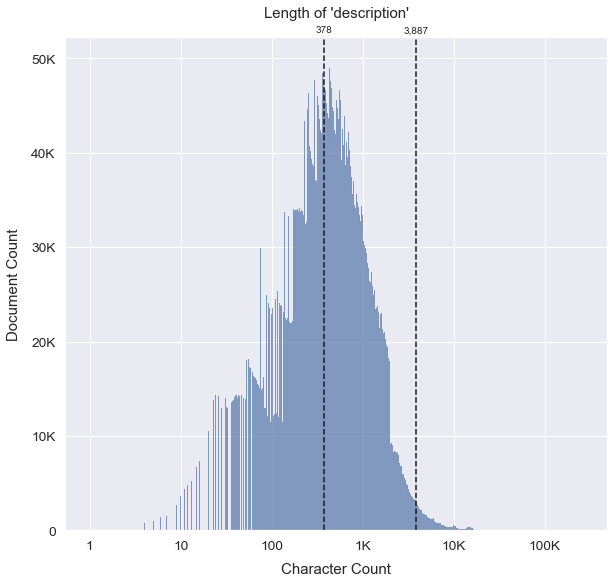

<IPython.core.display.Javascript object>

In [17]:
fig = lang.length_dist(
    data=df, subset="description", log_scale=True, tick_prec=0, height=8
)
ax = fig.get_axes()[0]
lower = df.description.str.len().quantile(0.5)
upper = df.description.str.len().quantile(0.99)
plotting.annotate.draw_line(ax, x=lower)
plotting.annotate.draw_line(ax, x=upper)
fig.savefig("figures/length_outliers.svg", bbox_inches="tight")

In [18]:
df = lang.trim_length_outliers(df, subset="description", q_lower=0.5, q_upper=0.99)
df.head()

       len_description  len_main_cat
count        4,039,221     4,039,221
mean               976            35
std                618            56
min                379             4
25%                530             7
50%                766            11
75%              1,225            23
max              3,886           190


             n_trimmed  pct_trimmed
description  4,205,714           51
main_cat             0            0
total_obs    4,205,714           51


,description,main_cat
asin,,
B000ACRBT6,Plug and drive: no installation or activation ...,Cell Phones & Accessories
1628090340,"""If you're looking for a reliable guidebook, t...",Books
0998825719,In her captivating literary memoir Singers sto...,Books
B0058OJ00Y,Create a luxurious oasis of watery bliss in yo...,Tools & Home Improvement
1410494012,"""""Danger Close"" is a riveting and intensely pe...",Books


<IPython.core.display.Javascript object>

The following is now the shortest product description. It's a mere 379 characters, but seems long enough to be useful. I can't imagine getting much use out of anything shorter. That said, I do plan on concatenating the description with a couple other text features.

In [19]:
df.at[df.description.str.len().idxmin(), "description"]

"Yu-Gi-Oh! is a strategic trading card game in which two players Duel each other using a variety of Monster, Spell, and Trap Cards to defeat their opponent's monsters and be the first to drop the other's Life Points to 0. Card Name : Ryko, Lightsworn Hunter Card Type : Effect Monster Card Number : SDLI-EN015 Set : Realms of Light Attribute : Light Level : 2 Monster Type : Beast"

<IPython.core.display.Javascript object>

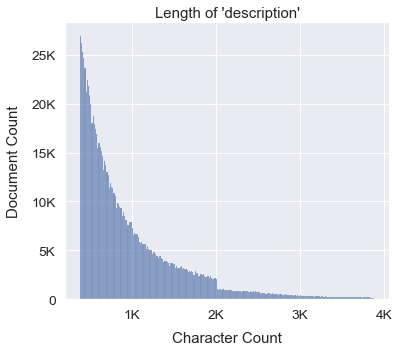

<IPython.core.display.Javascript object>

In [20]:
fig = lang.length_dist(df.sample(10 ** 6), subset="description")

The document lengths are now more or less on the same order of magnitude. I hope I've gotten rid of the anomalies.

# Cleaning 'main_cat'

The next step is to clean up the target variable: 'main_cat'.

In [21]:
# Get mask of samples with HTML
is_html = df["main_cat"].str.match(r"^<\w+")

# Extract `alt` property
df.loc[is_html, "main_cat"] = (
    df.loc[is_html, "main_cat"].str.extract(r"alt=\"(.+)\"").squeeze()
)
df["main_cat"].unique()

array(['Cell Phones & Accessories', 'Books', 'Tools & Home Improvement',
       'Digital Music', 'Sports & Outdoors', 'AMAZON FASHION',
       'All Electronics', 'Software', 'Computers', 'Home Audio & Theater',
       'Grocery', 'Movies & TV', 'Office Products', 'Camera & Photo',
       'Home Audio &amp; Theater', 'Arts, Crafts & Sewing',
       'Musical Instruments', 'Toys & Games', 'Luxury Beauty',
       'Automotive', 'Industrial & Scientific', 'Camera &amp; Photo',
       'Video Games', 'Amazon Home', 'Fine Art', 'Car Electronics',
       'Health & Personal Care', 'Pet Supplies', 'Appliances', 'Baby',
       'Prime Pantry', 'Magazine Subscriptions', 'All Beauty',
       'Cell Phones &amp; Accessories', 'Handmade', 'GPS & Navigation',
       'Portable Audio & Accessories', 'Sports &amp; Outdoors',
       'Industrial &amp; Scientific', 'Tools &amp; Home Improvement',
       'Toys &amp; Games', 'AMAZON LAUNCHPAD',
       'Health &amp; Personal Care', 'Movies &amp; TV',
       'Collect

<IPython.core.display.Javascript object>

Next, I decode HTML entities and convert to lowercase. By "HTML entities," I mean those codes like `&amp;` you see above.

In [22]:
steps = [lang.decode_html_entities, lang.lowercase]

df["main_cat"] = lang.chain_processors(df.loc[:, "main_cat"], steps, n_jobs=-1)
df["main_cat"].unique()

array(['cell phones & accessories', 'books', 'tools & home improvement',
       'digital music', 'sports & outdoors', 'amazon fashion',
       'all electronics', 'software', 'computers', 'home audio & theater',
       'grocery', 'movies & tv', 'office products', 'camera & photo',
       'arts, crafts & sewing', 'musical instruments', 'toys & games',
       'luxury beauty', 'automotive', 'industrial & scientific',
       'video games', 'amazon home', 'fine art', 'car electronics',
       'health & personal care', 'pet supplies', 'appliances', 'baby',
       'prime pantry', 'magazine subscriptions', 'all beauty', 'handmade',
       'gps & navigation', 'portable audio & accessories',
       'amazon launchpad', 'collectibles & fine art', 'gift cards',
       'amazon devices', 'buy a kindle', 'fire phone', 'beats by dr. dre',
       'entertainment', 'apple products', 'amazon fire tv',
       'sports collectibles'], dtype=object)

<IPython.core.display.Javascript object>

Next, I examine the class balance.

In [23]:
df["main_cat"].value_counts()

books                           986192
amazon home                     501425
amazon fashion                  471307
sports & outdoors               250305
tools & home improvement        208458
toys & games                    206248
automotive                      196355
grocery                         148852
cell phones & accessories       147917
digital music                   117238
movies & tv                     102011
computers                        98551
office products                  73193
all electronics                  70414
pet supplies                     65073
industrial & scientific          61799
camera & photo                   60333
arts, crafts & sewing            60041
home audio & theater             45351
musical instruments              44605
video games                      28036
health & personal care           22546
baby                             12733
software                         12304
car electronics                  11273
all beauty               

<IPython.core.display.Javascript object>

Looks pretty imbalanced, but serviceable. I'll drop the extremely small classes with less than 100 samples.

In [24]:
df = utils.prune_categories(df, column="main_cat", cut=100)

                                Status  Support
books                         retained   986192
amazon home                   retained   501425
amazon fashion                retained   471307
sports & outdoors             retained   250305
tools & home improvement      retained   208458
toys & games                  retained   206248
automotive                    retained   196355
grocery                       retained   148852
cell phones & accessories     retained   147917
digital music                 retained   117238
movies & tv                   retained   102011
computers                     retained    98551
office products               retained    73193
all electronics               retained    70414
pet supplies                  retained    65073
industrial & scientific       retained    61799
camera & photo                retained    60333
arts, crafts & sewing         retained    60041
home audio & theater          retained    45351
musical instruments           retained  

<IPython.core.display.Javascript object>

I define a function below for saving the data throughout this notebook. By saving periodically, I can avoid having to rerun the whole notebook.

In [17]:
def data_checkpoint(data, path):
    """Save data to disk."""
    path = os.path.normpath(path)

    if os.path.isdir(path):
        shutil.rmtree(path)
        print("Overwriting...")

    data.to_parquet(
        path,
        engine="pyarrow",
        index=True,
        partition_cols=["main_cat"],
    )

    n_files = len(glob.glob(f"{path}/*/*.parquet"))
    print(f"{n_files} files created.")

<IPython.core.display.Javascript object>

In [26]:
data_checkpoint(df, "data/skeleton_checkpoint")

Overwriting...
37 files created.


<IPython.core.display.Javascript object>

# Adding 'title' and 'brand'

The next step is to load the 'title' and 'brand' features.

In [27]:
titles = pd.read_parquet(
    "data/amazon_raw", engine="pyarrow", columns=["title", "brand", "asin"]
)
titles

,title,brand,asin
0,"Women Blouse, Ninasill Hooded Sweatshirt Coat ...",Ninasill_Blouse,6305121869
1,Coolred-Women Retro Split Sexy Skinny Premium ...,Coolred-Women,6318708057
2,Gaok Men's Retro Cotton Multi-Pocket Camo Carg...,Gaok,6342506256
3,QIBOE Men's Baggy Jeans Denim Sweatpants Loose...,QIBOE,6342509379
4,Crazy Explosion-proof Lens Polarized Sunglasse...,OLO,6342522081
...,...,...,...
15023054,Woodstock Percussion FBBS Fiesta Bamboo Blue S...,Woodstock Chimes,B0007IQV2Q
15023055,Woodstock Percussion MBC Mission Bamboo Chime,Woodstock Chimes,B0007IQV0I
15023056,Sunsei 70440 Solar Vent Stainless Steel Day/Ni...,ICP,B0007KGWGY
15023057,Valley Forge 20-Foot Aluminum In Ground Pole W...,Valley Forge,B0007KP9P4


<IPython.core.display.Javascript object>

Then I drop duplicates from the ID column 'asin' and set it as the index.

In [28]:
titles = titles.drop_duplicates(subset=["asin"])
titles = titles.set_index("asin")
titles.head()

,title,brand
asin,,
6305121869,"Women Blouse, Ninasill Hooded Sweatshirt Coat ...",Ninasill_Blouse
6318708057,Coolred-Women Retro Split Sexy Skinny Premium ...,Coolred-Women
6342506256,Gaok Men's Retro Cotton Multi-Pocket Camo Carg...,Gaok
6342509379,QIBOE Men's Baggy Jeans Denim Sweatpants Loose...,QIBOE
6342522081,Crazy Explosion-proof Lens Polarized Sunglasse...,OLO


<IPython.core.display.Javascript object>

I slice out the intersection between `titles` and `df`, discarding any samples which I previously discarded.

In [29]:
titles = titles.loc[titles.index.intersection(df.index)]
titles.shape

(4039200, 2)

<IPython.core.display.Javascript object>

Then I drop duplicates with respect to 'title' and 'brand'. Anything with the same title and brand is too close for comfort.

In [30]:
titles = titles.drop_duplicates(subset=["title", "brand"])
titles.shape

(4017825, 2)

<IPython.core.display.Javascript object>

Looks like that shaved off about 20K samples. Not bad. Next, I'll survey the length distributions.

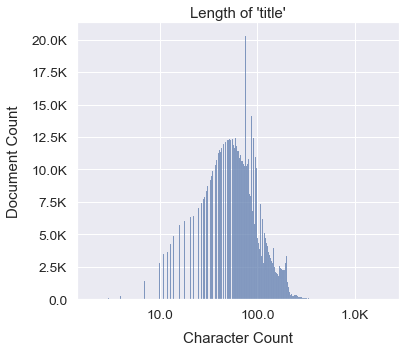

<IPython.core.display.Javascript object>

In [31]:
fig = lang.length_dist(
    titles.sample(10 ** 6), subset="title", log_scale=True, tick_prec=1
)

Short titles don't bother me, but I'm worried about the extremely long ones. Let's look at the longest.

In [32]:
titles.at[titles.title.str.len().idxmax(), "title"]

'NP-FH50 Li-ion Battery Replacement For Sony Alpha AC-VQH10, DSLR-A230, DSLR-A290, DSLR-A330, SLR-380, DSLR-A390, DSC-HX1, DSC-HX100, DSC-HX100V, SC-X200, DSC-HX200V, DCR-DVD103, DCR-DVD105, DCR-DVD105E, DCR-DVD106, DCR-DVD106E, DCR-DVD108, DCR-DVD109, DCR-DVD109E, DCR-DVD202, DCR-DVD202E,DCR-DVD203, DCR-DVD203E, DCR-DVD205, DCR-DVD205E, DCR-DVD305, DCR-DVD305E, DCR-DVD306, DCR-DVD306E, DCR-DVD308, DCR-DVD308E , DCR-DVD403, DCR-DVD403E, DCR-DVD404, DCR-DVD404E, DCR-DVD405, DCR-DVD405E, DCR-DVD406, DCR-DVD406E, DCR-DVD407, DCR-DVD407E, DCR-DVD408, DCR-DVD505, DCR-DVD505E, DCR-DVD506, DCR-DVD508, DCR-DVD602, DCR-DVD602E, DCR-DVD605, DCR-DVD605E, DCR-DVD610, DCR-DVD610E, DCR-DVD650, DCR-DVD653, DCR-DVD653E, DCR-DVD703, DCR-DVD703E, DCR-DVD705, DCR-DVD705E, DCR-DVD708, DCR-DVD708E, DCR-DVD710, DCR-DVD710E, DCR-DVD755, DCR-DVD755E, DCR-DVD803, DCR-DVD803E, DCR-DVD805, DCR-DVD805E, DCR-DVD808, DCRDVD808, DVD808, DCR-DVD808E, DCRDVD808E, DVD808E DCR-DVD810, DCR-DVD810E, DCR-DVD850, DCR-DVD850

<IPython.core.display.Javascript object>

It's a long list of alphanumeric codes. They look to be SKUs of compatible products. Since I'm building a natural language model and not a repository of codes, I'll drop the ultra-long titles. I'll also go ahead and drop the ultra-short titles by shaving off 1% from each tail of the distribution.

In [33]:
titles = lang.trim_length_outliers(titles, subset="title", q_inner=0.98)
titles

       len_title  len_brand
count  3,935,434  3,770,541
mean          69         15
std           38         10
min           10          1
25%           41          7
50%           62         12
75%           86         18
max          203      1,986


           n_trimmed  pct_trimmed
title         82,354            2
brand              0            0
total_obs     82,354            2


,title,brand
asin,,
6305121869,"Women Blouse, Ninasill Hooded Sweatshirt Coat ...",Ninasill_Blouse
6318708057,Coolred-Women Retro Split Sexy Skinny Premium ...,Coolred-Women
6342506256,Gaok Men's Retro Cotton Multi-Pocket Camo Carg...,Gaok
6342509379,QIBOE Men's Baggy Jeans Denim Sweatpants Loose...,QIBOE
6342522081,Crazy Explosion-proof Lens Polarized Sunglasse...,OLO
...,...,...
B0007IIOE4,19HP 42&quot; Yard Tractor,Electrolux
B0007IN33G,Echo Valley EV4061 Low Profile Globe Stand Black,Echo Valley
B0007IQUUO,"Woodstock Chimes CRCBM Craftsman Chime, Black",Woodstock Chimes


<IPython.core.display.Javascript object>

Much better. The longest title is now ~200 characters, and the shortest is ~10. Time to merge `titles` with `df`.

In [34]:
df = pd.merge(df, titles, left_index=True, right_index=True)
df

,description,main_cat,title,brand
asin,,,,
B000ACRBT6,Plug and drive: no installation or activation ...,cell phones & accessories,TomTom Rider 3.5-Inch Bluetooth Portable GPS N...,TomTom
1628090340,"""If you're looking for a reliable guidebook, t...",books,The Unofficial Guide to Mall of America (Unoff...,Visit Amazon's Beth Blair Page
0998825719,In her captivating literary memoir Singers sto...,books,California Calling: A Self-Interrogation,Visit Amazon's Natalie Singer Page
B0058OJ00Y,Create a luxurious oasis of watery bliss in yo...,tools & home improvement,Moen TS296BN ioDIGITAL Vertical Spa Kit with V...,Moen
1410494012,"""""Danger Close"" is a riveting and intensely pe...",books,Danger Close: One Woman's Epic Journey as a Co...,Amber Smith
...,...,...,...,...
B00CA8PIKW,Sellstrom Grafit series black frame shade 5 IR...,industrial & scientific,Sellstrom 76251 Grafit Series Protective Eyewe...,Sellstrom
B001G8XILS,What comes up must come down in great looking ...,tools & home improvement,Ergodyne Arsenal 5712 Canvas Utility Pouch - S...,Ergodyne
B00FSFO93G,OMHome Two-Piece Pajamas - Blue Suitable for b...,amazon fashion,OM Home Unisex Baby Two-Piece Pajamas,OM Home


<IPython.core.display.Javascript object>

In [35]:
del titles

<IPython.core.display.Javascript object>

# Filtering Text

Next, I apply some basic preprocessing filters to the text. I begin by decoding HTML entities and lowercasing. If you recall, I defined a list of functions earlier called `steps`.

In [36]:
steps

[<function tools.language.processors.text.decode_html_entities(docs: Union[str, Iterable[str]], n_jobs=None) -> Union[str, Iterable[str]]>,
 <function tools.language.processors.text.lowercase(docs: Union[str, Iterable[str]], n_jobs=None) -> Union[str, Iterable[str]]>]

<IPython.core.display.Javascript object>

In [37]:
df.update(
    # Apply `steps` as a pipeline, elementwise
    lang.chain_processors(
        df.loc[:, ["description", "title", "brand"]],
        steps,
        n_jobs=-1,
    )
)
df.head()

,description,main_cat,title,brand
asin,,,,
B000ACRBT6,plug and drive: no installation or activation ...,cell phones & accessories,tomtom rider 3.5-inch bluetooth portable gps n...,tomtom
1628090340,"""if you're looking for a reliable guidebook, t...",books,the unofficial guide to mall of america (unoff...,visit amazon's beth blair page
0998825719,in her captivating literary memoir singers sto...,books,california calling: a self-interrogation,visit amazon's natalie singer page
B0058OJ00Y,create a luxurious oasis of watery bliss in yo...,tools & home improvement,moen ts296bn iodigital vertical spa kit with v...,moen
1410494012,"""""danger close"" is a riveting and intensely pe...",books,danger close: one woman's epic journey as a co...,amber smith


<IPython.core.display.Javascript object>

Next I'll remove HTML tags from 'title' and 'brand'. I know there are an abundance of them in this dataset.

In [38]:
df.update(lang.strip_html_tags(df.loc[:, ["title", "brand"]], n_jobs=-1))
df.head()

,description,main_cat,title,brand
asin,,,,
B000ACRBT6,plug and drive: no installation or activation ...,cell phones & accessories,tomtom rider 3.5-inch bluetooth portable gps n...,tomtom
1628090340,"""if you're looking for a reliable guidebook, t...",books,the unofficial guide to mall of america (unoff...,visit amazon's beth blair page
0998825719,in her captivating literary memoir singers sto...,books,california calling: a self-interrogation,visit amazon's natalie singer page
B0058OJ00Y,create a luxurious oasis of watery bliss in yo...,tools & home improvement,moen ts296bn iodigital vertical spa kit with v...,moen
1410494012,"""""danger close"" is a riveting and intensely pe...",books,danger close: one woman's epic journey as a co...,amber smith


<IPython.core.display.Javascript object>

## Dropping Nulls

Next, I'll drop 0-length documents after clearing any extra whitespace that may be around.

In [39]:
df.update(lang.strip_extra_space(df, n_jobs=-1))
df.head()

,description,main_cat,title,brand
asin,,,,
B000ACRBT6,plug and drive: no installation or activation ...,cell phones & accessories,tomtom rider 3.5-inch bluetooth portable gps n...,tomtom
1628090340,"""if you're looking for a reliable guidebook, t...",books,the unofficial guide to mall of america (unoff...,visit amazon's beth blair page
0998825719,in her captivating literary memoir singers sto...,books,california calling: a self-interrogation,visit amazon's natalie singer page
B0058OJ00Y,create a luxurious oasis of watery bliss in yo...,tools & home improvement,moen ts296bn iodigital vertical spa kit with v...,moen
1410494012,"""""danger close"" is a riveting and intensely pe...",books,danger close: one woman's epic journey as a co...,amber smith


<IPython.core.display.Javascript object>

In [40]:
# Convert 0-length strings to null
df = df.mask(df.applymap(len, "ignore") == 0)
df.isna().sum()

description         0
main_cat            0
title            4161
brand          165061
dtype: int64

<IPython.core.display.Javascript object>

I leave the 'brand' nulls intact for now. I will revisit them later.

In [41]:
df = df.dropna(subset=["description", "title", "main_cat"])
df.shape

(3931310, 4)

<IPython.core.display.Javascript object>

## Dropping Duplicates

Next, I drop duplicates again after filtering. I look for duplicates with respect to both 'title' and 'brand', and also with respect to 'description'.

In [42]:
df = df.drop_duplicates(subset=["title", "brand"])
df = df.drop_duplicates(subset=["description"])
df.shape

(3887490, 4)

<IPython.core.display.Javascript object>

That shaved off tens of thousands of samples. Pretty good.

Now to save the filtered text.

In [46]:
data_checkpoint(df, "data/filter_checkpoint")

37 files created.


<IPython.core.display.Javascript object>

## Revisiting Length Outliers

I plot length distributions on a linear scale to see if anything has changed.

In [47]:
df = pd.read_parquet("data/filter_checkpoint", engine="pyarrow")
df.head()

,description,title,brand,main_cat
asin,,,,
B00APG79QM,100% cotton pillow protectors effectively bloc...,temporary hair chalk - non-toxic rainbow color...,sysrion,all beauty
B00CZH3FGM,"view larger prepare to flash a brighter, white...","crest + oral-b professional whitening kit, 1 c...",crest,all beauty
B000KMCSG2,the limited edition philips norelco smarttouch...,philips norelco 9199xl limited edition formula...,philips norelco,all beauty
B001E0C9LI,"the all-over bodygrooming system, with specifi...",philips norelco bg2030 professional bodygroomi...,philips norelco,all beauty
B0000530SM,premium whitening toothpaste with fluoride fre...,"rembrandt dazzling white toothpaste - mint, (5...",rembrandt,all beauty


<IPython.core.display.Javascript object>

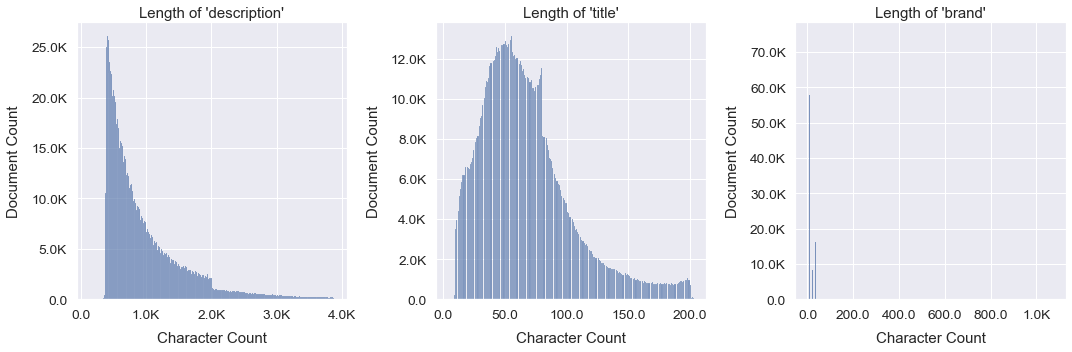

<IPython.core.display.Javascript object>

In [48]:
fig = lang.length_dist(
    df.sample(10 ** 6),
    subset=["description", "title", "brand"],
    tick_prec=1,
)

In [49]:
lang.other.length_info(df)

       len_description  len_title  len_brand
count        3,887,490  3,887,490  3,723,595
mean               972         68         15
std                616         38         10
min                 88          2          1
25%                528         41          7
50%                761         61         12
75%              1,216         85         18
max              3,886        203      1,986


<IPython.core.display.Javascript object>

Looks like my filtering has resulted in a few very short titles and descriptions. I'll ignore brands for the moment, but trim the shortest 1% of titles and descriptions.

In [50]:
df = lang.trim_length_outliers(
    df,
    subset=["title", "description"],
    q_lower=0.01,
)
df.head()

       len_description  len_title  len_brand  len_main_cat
count        3,796,286  3,796,286  3,635,321     3,796,286
mean               976         68         15            12
std                614         37         10             6
min                384         13          1             4
25%                533         42          7             7
50%                767         62         12            11
75%              1,221         85         18            15
max              3,885        202      1,986            28


             n_trimmed  pct_trimmed
description     44,223            1
title           47,360            1
brand                0            0
main_cat             0            0
total_obs       91,204            2


,description,title,brand,main_cat
asin,,,,
B00APG79QM,100% cotton pillow protectors effectively bloc...,temporary hair chalk - non-toxic rainbow color...,sysrion,all beauty
B00CZH3FGM,"view larger prepare to flash a brighter, white...","crest + oral-b professional whitening kit, 1 c...",crest,all beauty
B000KMCSG2,the limited edition philips norelco smarttouch...,philips norelco 9199xl limited edition formula...,philips norelco,all beauty
B001E0C9LI,"the all-over bodygrooming system, with specifi...",philips norelco bg2030 professional bodygroomi...,philips norelco,all beauty
B0000530SM,premium whitening toothpaste with fluoride fre...,"rembrandt dazzling white toothpaste - mint, (5...",rembrandt,all beauty


<IPython.core.display.Javascript object>

I haven't trimmed the brands yet, but clearly the massive positive skew is a problem. Apparently the longest brand name is ~2K characters. I can tell just by the character count that I need to drop the longest 1%.

In [51]:
df = lang.trim_length_outliers(
    df,
    subset="brand",
    q_upper=0.99,
)
df.head()

       len_description  len_title  len_brand  len_main_cat
count        3,751,304  3,751,304  3,590,339     3,751,304
mean               973         68         14            12
std                611         37          9             6
min                384         13          2             4
25%                533         42          7             7
50%                765         62         11            11
75%              1,216         85         18            15
max              3,885        202         39            28


             n_trimmed  pct_trimmed
description          0            0
title                0            0
brand           44,982            1
main_cat             0            0
total_obs       44,982            1


,description,title,brand,main_cat
asin,,,,
B00APG79QM,100% cotton pillow protectors effectively bloc...,temporary hair chalk - non-toxic rainbow color...,sysrion,all beauty
B00CZH3FGM,"view larger prepare to flash a brighter, white...","crest + oral-b professional whitening kit, 1 c...",crest,all beauty
B000KMCSG2,the limited edition philips norelco smarttouch...,philips norelco 9199xl limited edition formula...,philips norelco,all beauty
B001E0C9LI,"the all-over bodygrooming system, with specifi...",philips norelco bg2030 professional bodygroomi...,philips norelco,all beauty
B0000530SM,premium whitening toothpaste with fluoride fre...,"rembrandt dazzling white toothpaste - mint, (5...",rembrandt,all beauty


<IPython.core.display.Javascript object>

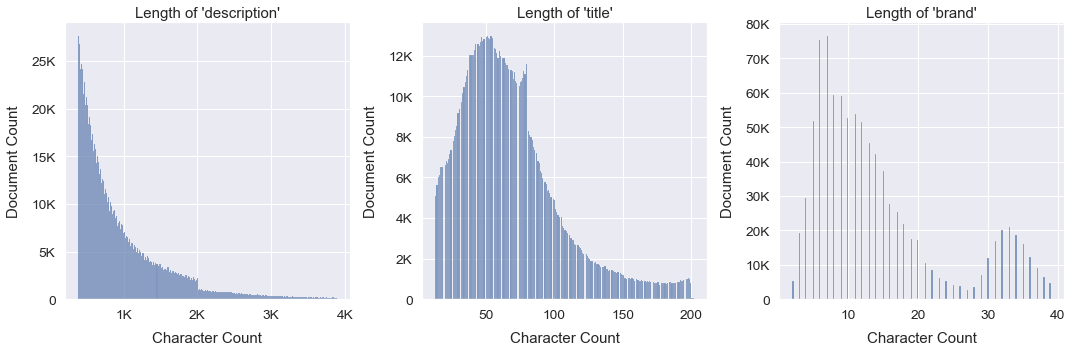

<IPython.core.display.Javascript object>

In [52]:
fig = lang.length_dist(df.sample(10 ** 6), subset=["description", "title", "brand"])

The lengths are looking pretty good, considering how skewed they were to begin with. These are plotted on a linear scale.

In [53]:
data_checkpoint(df, "data/length_checkpoint")

Overwriting...
37 files created.


<IPython.core.display.Javascript object>

# Clean Brand

Now I'll do my best to clean up the 'brand' feature. I expect it to have a strong relationship with category.

In [54]:
df = pd.read_parquet("data/length_checkpoint", engine="pyarrow")
df.head()

,description,title,brand,main_cat
asin,,,,
B00APG79QM,100% cotton pillow protectors effectively bloc...,temporary hair chalk - non-toxic rainbow color...,sysrion,all beauty
B00CZH3FGM,"view larger prepare to flash a brighter, white...","crest + oral-b professional whitening kit, 1 c...",crest,all beauty
B000KMCSG2,the limited edition philips norelco smarttouch...,philips norelco 9199xl limited edition formula...,philips norelco,all beauty
B001E0C9LI,"the all-over bodygrooming system, with specifi...",philips norelco bg2030 professional bodygroomi...,philips norelco,all beauty
B0000530SM,premium whitening toothpaste with fluoride fre...,"rembrandt dazzling white toothpaste - mint, (5...",rembrandt,all beauty


<IPython.core.display.Javascript object>

I examine the top brands.

In [55]:
brand_counts = df["brand"].value_counts()
brand_counts.head(15)

generic                 10079
unknown                  8903
yu-gi-oh!                7072
magic: the gathering     6475
invicta                  6021
sony                     4860
amazon collection        4839
various artists          4609
samsung                  4099
evan fischer             4022
hp                       3775
various                  3724
toogoo(r)                3660
3drose                   3587
empire                   3548
Name: brand, dtype: int64

<IPython.core.display.Javascript object>

Next I put together a list of null placeholders. I'll have to add to the list whenever I spot a new one.

In [56]:
null_brands = [
    "generic",
    "n/a",
    "no brand",
    "none",
    "not available",
    "null",
    "unavailable",
    "unbranded",
    "unknown",
    "learn more",
    "other",
    "anonymous",
]

brand_counts.loc[null_brands].sort_values()

unavailable          1
no brand             5
null                27
unbranded           76
other              104
not available      108
anonymous          108
learn more         223
n/a                545
none               620
unknown           8903
generic          10079
Name: brand, dtype: int64

<IPython.core.display.Javascript object>

In [57]:
df.loc[df.brand == "generic"]

,description,title,brand,main_cat
asin,,,,
B019E906LU,digital printing studio vinyl floor christmas ...,5x7ft study books photograghy backdrops photo ...,generic,all beauty
B00246EHKW,*check out the 90 day supply (3 bottles) save ...,gain weight fast with safe weight gain pills -...,generic,all beauty
B0017SWH5A,designed specifically for pet owners. austin a...,austin air pet machine air purifier - black - ...,generic,all beauty
B00OUQOJ8Y,savfy iphone 6 backup power bank (3200 mah) ca...,"savfy® iphone 6 4.7"" 4.7 inch 3200mah backup b...",generic,all beauty
B0095NXF5U,use this item to tape down lower lashes before...,double eyelid eye beauty tape with scissors,generic,all beauty
...,...,...,...,...
B00WJGWIUS,"features: easy to install and dismantle, effec...",generic full housing shell case button kit rep...,generic,video games
B00ITE71U6,features: high quality noctilucence silicone s...,generic glow noctilucence cover silicone skin ...,generic,video games
B004EL94AI,salem secrets takes you into the haunting tale...,hidden mysteries: salem secrets - witch trials...,generic,video games


<IPython.core.display.Javascript object>

In [58]:
if "generic" in null_brands:
    null_brands.remove("generic")
df.loc[df.brand.isin(null_brands), "brand"] = np.nan
df.isna().sum()

description         0
title               0
brand          171685
main_cat            0
dtype: int64

<IPython.core.display.Javascript object>

In [59]:
by_brands = df.brand.str.startswith("by ").dropna()
df.dropna().loc[by_brands, ["brand"]]

,brand
asin,
B01CMJZLXM,by alegory
B00KUSQ9NY,by alegory
B00CMSCV32,by sega
B00LZWGVFA,by gunnar optiks
B00K0SXUBS,by w5swl
...,...
B0046RROE8,by ethahe
B00002S5FG,by microsoft
B001AXHL08,by jwin


<IPython.core.display.Javascript object>

In [60]:
df["brand"] = df.loc[:, "brand"].str.replace("^(by\s+)", "", regex=True)
df.dropna().loc[by_brands, ["brand"]]

,brand
asin,
B01CMJZLXM,alegory
B00KUSQ9NY,alegory
B00CMSCV32,sega
B00LZWGVFA,gunnar optiks
B00K0SXUBS,w5swl
...,...
B0046RROE8,ethahe
B00002S5FG,microsoft
B001AXHL08,jwin


<IPython.core.display.Javascript object>

In [61]:
amazon_pages = df.brand.str.extract(r"visit amazon's (.+) page")
amazon_pages = amazon_pages.dropna().squeeze()
df.loc[amazon_pages.index, "brand"] = amazon_pages
df.loc[amazon_pages.index]

,description,title,brand,main_cat
asin,,,,
0143110098,"“a fresh, thrilling portrait… guy’s elizabeth ...",elizabeth: the later years,john guy,books
0815729103,shivshankar menon's choices is a short book co...,choices: inside the making of indias foreign p...,shivshankar menon,books
1501129090,the book is written in a clear and easy to fol...,guided: reclaiming the intuitive voice of your...,hans christian king,books
1492264997,death in the australian outback: the australia...,death in the australian outback (bigfoot littl...,anthony e thorogood,books
0738715034,""" goddess to the core is a wonderfully present...",goddess to the core: an inspired workout to ma...,sierra bender,books
...,...,...,...,...
1425177654,"emelia sam currently resides in washington, dc...",i haven't found myself... but i'm still lookin...,emelia sam,books
1501187538,ania ahlborn is the bestselling author of the ...,apart in the dark: novellas,ania ahlborn,books
0521478081,"""the most sensitive and intelligent book in th...",franois truffaut,annette insdorf,books


<IPython.core.display.Javascript object>

In [62]:
regex = df.brand.value_counts().reset_index()
regex.columns = ["brand", "support"]
regex["brand"] = lang.strip_non_word(regex.loc[:, "brand"])
regex = regex.loc[
    (~regex.brand.str.contains("\s", regex=True))
    & (regex.brand != "various")
    & (regex.brand.str.len() > 3)
]
regex["brand"] = r"^" + regex.brand.map(re.escape) + r"\b"
regex.head(20)

,brand,support
0,^generic\b,10138
3,^invicta\b,6021
4,^sony\b,5357
7,^samsung\b,4099
12,^3drose\b,3587
13,^empire\b,3549
14,^uxcell\b,3379
16,^pokemon\b,3181
17,^disney\b,3134
18,^seiko\b,2699


<IPython.core.display.Javascript object>

In [63]:
no_brand = df.loc[df.brand.isna()]
fillers = lang.locate_patterns(regex.brand.head(100), no_brand.title)
fillers.sort_values()

asin
B0174OFIZ6          acer
B00005U2P0    activision
B003DXAAPG        adidas
B00L2N3EZC        adidas
B00L2IPZ5Y        adidas
                 ...    
B00KMONWNG        vktech
B00963S6TE        yamaha
B004NT8VRS        yamaha
B00IWKVSR4        yamaha
B005M3JQ9Q        yamaha
Name: locate_patterns, Length: 10418, dtype: object

<IPython.core.display.Javascript object>

In [64]:
df.loc[fillers.index, "brand"] = fillers
df.loc[fillers.index]

,description,title,brand,main_cat
asin,,,,
0898983428,628 pages of incredible sheet music for piano ...,columbia's colossal fake book (f2332fbx),columbia,books
1405288027,what would you do if you were famous? what's y...,lego (r) ninjago: book of secrets,lego,books
1423122607,#1 new york times bestselling author and illus...,disney princess collection (storybook collection),disney,books
145081137X,the disney school years memory keeper is a stu...,disney school years memory keeper,disney,books
1455039608,your daughter will love this disney princess 1...,disney princess storybook library set (volumes...,disney,books
...,...,...,...,...
B01HILUTZO,the nike zoom lebron soldier 10 mens basketbal...,nike men's lebron 10 basketball shoe,nike,amazon fashion
B01HIMR5E6,the adidas® kids altarun boosts style and perf...,adidas kids womens altarun (little kid/big kid),adidas,amazon fashion
B01HINBHRG,"from the playground to the court, have them re...",adidas kids' altasport running shoe,adidas,amazon fashion


<IPython.core.display.Javascript object>

In [65]:
df.isna().sum()

description         0
title               0
brand          161267
main_cat            0
dtype: int64

<IPython.core.display.Javascript object>

In [66]:
no_brand = df.isna().groupby(df.main_cat).sum()[["brand"]]
no_brand["support"] = df.main_cat.value_counts()
no_brand = no_brand.rename(columns={"brand": "null_brand"})
no_brand["frac_null"] = no_brand["null_brand"] / no_brand["support"]
no_brand.sort_values("frac_null", ascending=False).head(10).style.bar("frac_null")

,null_brand,support,frac_null
main_cat,,,
fine art,280,280,1.000000
luxury beauty,6623,6631,0.998794
handmade,2212,2227,0.993264
magazine subscriptions,2,3,0.666667
movies & tv,22979,87791,0.261747
amazon fashion,107538,451819,0.238011
gift cards,10,140,0.071429
all beauty,504,10187,0.049475
collectibles & fine art,45,952,0.047269


<IPython.core.display.Javascript object>

In [67]:
df.loc[df.brand.isna(), "brand"] = ""
df.brand.value_counts().head(10)

                        161267
generic                  10190
yu-gi-oh!                 7072
magic: the gathering      6475
invicta                   6021
nike                      5811
sony                      5379
adidas                    5079
amazon collection         4839
various artists           4610
Name: brand, dtype: int64

<IPython.core.display.Javascript object>

## Revisiting Class Balance

In [68]:
df = utils.prune_categories(df, "main_cat", cut=100)

                                Status  Support
books                         retained   879359
amazon home                   retained   480704
amazon fashion                retained   451819
sports & outdoors             retained   239447
tools & home improvement      retained   202021
toys & games                  retained   199664
automotive                    retained   187736
grocery                       retained   144866
cell phones & accessories     retained   133852
computers                     retained    91048
movies & tv                   retained    87791
digital music                 retained    83154
office products               retained    69175
all electronics               retained    66592
pet supplies                  retained    61123
industrial & scientific       retained    58771
arts, crafts & sewing         retained    57123
camera & photo                retained    54676
musical instruments           retained    43259
home audio & theater          retained  

<IPython.core.display.Javascript object>

In [69]:
data_checkpoint(df, "data/brand_checkpoint")

Overwriting...
36 files created.


<IPython.core.display.Javascript object>

# Adding 'feature' text

In [3]:
df = pd.read_parquet("data/brand_checkpoint", engine="pyarrow")
df.head()

,description,title,brand,main_cat
asin,,,,
B00APG79QM,100% cotton pillow protectors effectively bloc...,temporary hair chalk - non-toxic rainbow color...,sysrion,all beauty
B00CZH3FGM,"view larger prepare to flash a brighter, white...","crest + oral-b professional whitening kit, 1 c...",crest,all beauty
B000KMCSG2,the limited edition philips norelco smarttouch...,philips norelco 9199xl limited edition formula...,philips norelco,all beauty
B001E0C9LI,"the all-over bodygrooming system, with specifi...",philips norelco bg2030 professional bodygroomi...,philips norelco,all beauty
B0000530SM,premium whitening toothpaste with fluoride fre...,"rembrandt dazzling white toothpaste - mint, (5...",rembrandt,all beauty


<IPython.core.display.Javascript object>

In [4]:
feat = dd.read_parquet(
    "data/amazon_raw", columns="feature", index="asin", engine="pyarrow"
)
feat = feat.loc[feat.index.isin(df.index)].str.join(" ")
feat.head()

asin
6305121869    Import Versatile Occasions - Great for Daily,C...
6318708057    100% Spandex Order Larger If You are Between S...
6342506256    Cotton Zipper closure Material:100% cotton Zip...
6342509379    Denim Zipper closure Material: cotton Style: h...
6342522081    Material: Polycarbonate Main features: Windpro...
Name: feature, dtype: object

<IPython.core.display.Javascript object>

In [5]:
df = pd.merge(df, feat.compute(), left_index=True, right_index=True, copy=False)
df.head()

,description,title,brand,main_cat,feature
asin,,,,,
0000044806,ayurveda holds secrets for all our skin proble...,medimix ayurvedic facewash - 100 ml (pack of 2),medimix,health & personal care,None
0000060259,if you feel that applying powder kumkum is tir...,lakme jewel sindoor (maroon) - pack of 2,lakme,health & personal care,None
0000098906,frog - rubbing its spine with the wooden stick...,"wooden percussion 3 piece set frog, cricket an...",wadsuwan shop,musical instruments,Wood percussion Small 3 inches Creates origina...
0000143502,rise and swine (good eats vol. 7) includes bon...,rise and swine (good eats vol. 7),alton brown,movies & tv,None
0000143529,disc 1: flour power (scones; shortcakes; south...,my fair pastry (good eats vol. 9),alton brown,movies & tv,None


<IPython.core.display.Javascript object>

In [6]:
del feat

<IPython.core.display.Javascript object>

In [7]:
display(df.index.duplicated().sum())
df = df.loc[~df.index.duplicated()]
df.index.duplicated().sum()

89103

0

<IPython.core.display.Javascript object>

In [8]:
steps = [lang.decode_html_entities, lang.lowercase, lang.strip_html_tags]
df["feature"] = lang.chain_processors(df.loc[:, "feature"], steps, n_jobs=-1)
df["feature"].head()

asin
0000044806                                                 None
0000060259                                                 None
0000098906    wood percussion small 3 inches creates origina...
0000143502                                                 None
0000143529                                                 None
Name: feature, dtype: object

<IPython.core.display.Javascript object>

In [9]:
lang.length_info(df["feature"])

       len_feature
count    2,343,887
mean           562
std            526
min              0
25%            197
50%            348
75%            818
max          9,947


<IPython.core.display.Javascript object>

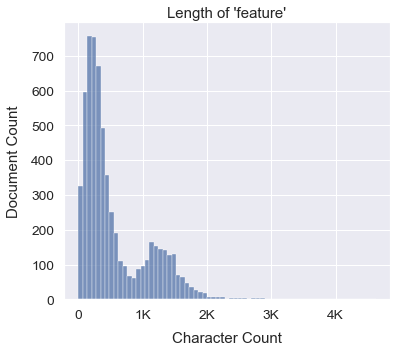

<IPython.core.display.Javascript object>

In [10]:
fig = lang.length_dist(
    df.sample(10 ** 4, random_state=39),
    subset=["feature"],
)

In [11]:
df.at[df.feature.str.len().idxmax(), "feature"]

'sony kde-55xbr950,kdl-55ex640,kdl-55ex620,kdl-60ex700,kdl-55hx820,kdl-60ex720,kdl-60nx720,kdl-60ex500,kdl-60nx800,kdl-40s3000,kdl-55bx520,kdl-40v2500,kdl-40v3000,kdl-40vl130,kdl-40z4100,kdl-40ex700,kdl-60ex723,nsx-40gt1,kdl-40s2000,kdl-40s20l1,kdl-40w3000,kdl-40xbr3,kdl-40sl130,kdl-40xbr9,kdl-40v5100,kdl-40ve5,kdl-40w4100,kdl-40ex600,kdl-40ex523,kdl-40ex401,kdl-40d3000,kdl-40xbr5,kdl-v40xbr1,klv-40s200a,kdl-40xbr6,kdl-40s5100,kdl-40bx450,kdl-40nx700,kdl-40ex720,kdl-40s504,kdl-40bx420,fwd-40lx2f,kdl-40s2400,kdl-40xbr2,kdl-40xbr4,klv-s40a10,klv-40u100m,kdl-40xbr7,kdl-40z5100,klv-40zx1m,kdl-40ex640,kdl-40ex400,fwd-40lx1,kdl-40s2010,fwd-42pv1p/b,fwd-42px2,kde-42xbr950,kde-42xs955,kdl-40w5100,pfm-42x1,kdl-42xbr950,ke-42ts2,pfm-42b1,pfm-42b2,kdl-40ex500,kz-42ts1,kz-42ts1j,kz-42ts1u,fwd-42lx1,fwd-42pv1as,pfm-42v1,ke-42m1,ke-42ts2u,pfm-42b1u,pfm-42b2h,ke-42xbr900,ke-42xs910,kdl-46s5100,kdl-46v5100,kdl-46s2000,kdl-46s2010,kdl-46bx420,fwd-42pv1,kdl-46ex500,kdl-46ex523,kdl-46ex720,kdl-46hx729,kd

<IPython.core.display.Javascript object>

In [12]:
df = lang.trim_length_outliers(df, subset="feature", method="iqr")

       len_description  len_title  len_brand  len_main_cat  len_feature
count        3,692,413  3,692,413  3,692,413     3,692,413    2,284,999
mean               971         68         11            12          518
std                611         37          6             6          446
min                384         13          0             4            0
25%                531         42          7             7          193
50%                761         61         11            11          338
75%              1,209         85         14            15          725
max              3,885        202         39            28        1,749


             n_trimmed  pct_trimmed
description          0            0
title                0            0
brand                0            0
main_cat             0            0
feature         58,888            2
total_obs       58,888            2


<IPython.core.display.Javascript object>

Next, I delete everything between brackets or parentheses.

In [13]:
longest_feat = df.feature.str.len().idxmax()
df.at[longest_feat, "feature"]

'invite nature to your yard: looking for yard decorations and accessories to draw beautiful wildlife right to your home? birds in the garden are looking for water to drink and splash in outdoors. the catttail birdbaths are a beautiful way to provide water for backyard birds year-round. makes a great gift for the avid gardener or bird-watcher. functional pieces of garden art: these botanical garden ornaments are outdoor pieces of sculpture to beautify your garden. the bright and lustrous hammered finish of the copper bowls create a beautiful contrast against the black spray of wrought iron leaves and cattails. they make an artful addition to any perennial bed, water feature, or natural setting in your yard. choose a style with one bowl or two. hand-made wrought iron and solid copper: the black leaves and cattails are handmade of fine wrought iron. the birdbath bowls are hand-hammered from solid copper, which will not rust, but develops a rich natural copper patina over time. catttail bi

<IPython.core.display.Javascript object>

In [14]:
df["feature"] = df.loc[:, "feature"].str.replace(r"([{\(].+[\)}])", "", regex=True)
df.at[longest_feat, "feature"]

'invite nature to your yard: looking for yard decorations and accessories to draw beautiful wildlife right to your home? birds in the garden are looking for water to drink and splash in outdoors. the catttail birdbaths are a beautiful way to provide water for backyard birds year-round. makes a great gift for the avid gardener or bird-watcher. functional pieces of garden art: these botanical garden ornaments are outdoor pieces of sculpture to beautify your garden. the bright and lustrous hammered finish of the copper bowls create a beautiful contrast against the black spray of wrought iron leaves and cattails. they make an artful addition to any perennial bed, water feature, or natural setting in your yard. choose a style with one bowl or two. hand-made wrought iron and solid copper: the black leaves and cattails are handmade of fine wrought iron. the birdbath bowls are hand-hammered from solid copper, which will not rust, but develops a rich natural copper patina over time. catttail bi

<IPython.core.display.Javascript object>

In [15]:
df["feature"].fillna("", inplace=True)
df.head()

,description,title,brand,main_cat,feature
asin,,,,,
0000044806,ayurveda holds secrets for all our skin proble...,medimix ayurvedic facewash - 100 ml (pack of 2),medimix,health & personal care,
0000060259,if you feel that applying powder kumkum is tir...,lakme jewel sindoor (maroon) - pack of 2,lakme,health & personal care,
0000098906,frog - rubbing its spine with the wooden stick...,"wooden percussion 3 piece set frog, cricket an...",wadsuwan shop,musical instruments,wood percussion small 3 inches creates origina...
0000143502,rise and swine (good eats vol. 7) includes bon...,rise and swine (good eats vol. 7),alton brown,movies & tv,
0000143529,disc 1: flour power (scones; shortcakes; south...,my fair pastry (good eats vol. 9),alton brown,movies & tv,


<IPython.core.display.Javascript object>

In [18]:
data_checkpoint(df, "data/feature_checkpoint")

Overwriting...
36 files created.


<IPython.core.display.Javascript object>

# Constructing Model Text

In [19]:
df = dd.read_parquet("data/feature_checkpoint", engine="pyarrow", index="asin")
df.head()

,description,title,brand,feature,main_cat
asin,,,,,
1441072241,after rising in the appalachian mountains of v...,come tell me how you lived: native american hi...,enter the arena,,all beauty
6090113980,note : we cannot guarantee 100% that you will ...,prayer rug carpet mat gebetsteppich islamic mu...,bonballoon,,all beauty
7250468162,no7 stay perfect foundation now stays perfect ...,no7 stay perfect foundation cool vanilla by no7,no7,,all beauty
8279996397,"according to the legend, in 1613, two brothers...",imagen bendita por su santidad our lady of cha...,chango,,all beauty
9197882747,"if you can design one thing, you can design ev...",hall of femmes: lella vignelli (hall of femmes),oyster press,,all beauty


<IPython.core.display.Javascript object>

In [20]:
text_schema = "{title}. {description}. {feature}. {brand}."


def construct_text(item, schema=text_schema):
    text = schema.format(**item)
    return lang.strip_extra_periods(text)


construct_text(df.head(1).squeeze())

'come tell me how you lived: native american history of the tennessee valley. after rising in the appalachian mountains of virginia and north carolina, the tennessee river flows in a southwesterly direction through tennessee making a bend to the west in alabama and touching mississippi. the river turns to the north through tennessee again and finally into kentucky where it joins the ohio river. for thousands of years, native americans lived in and around the river valley in great numbers. even though lakes from the tennessee valley authority dams have covered the evidence left at many of the indian sites, this book attempts to show how these first americans lived. numerous pictures are shown to help illustrate their long and interesting story. enter the arena.'

<IPython.core.display.Javascript object>

In [21]:
# Apply function row-wise
df["text"] = df.apply(construct_text, meta=str, axis=1)
df["text"].head()

asin
1441072241    come tell me how you lived: native american hi...
6090113980    prayer rug carpet mat gebetsteppich islamic mu...
7250468162    no7 stay perfect foundation cool vanilla by no...
8279996397    imagen bendita por su santidad our lady of cha...
9197882747    hall of femmes: lella vignelli (hall of femmes...
Name: text, dtype: object

<IPython.core.display.Javascript object>

# Export

In [22]:
df.to_parquet(
    "data/amazon_clean",
    engine="pyarrow",
    schema="infer",
    write_index=True,
    overwrite=True,
)

<IPython.core.display.Javascript object>

In [23]:
conf = input("Delete checkpoints? (y/n): ")
if strtobool(conf):
    for path in glob.glob("data/*_checkpoint"):
        shutil.rmtree(path)
        print(f"'{path}' deleted.")
else:
    print(f"Checkpoints not deleted.")

Delete checkpoints? (y/n): y
'data\brand_checkpoint' deleted.
'data\feature_checkpoint' deleted.
'data\filter_checkpoint' deleted.
'data\length_checkpoint' deleted.
'data\skeleton_checkpoint' deleted.


<IPython.core.display.Javascript object>